# 6주차 BASE MODEL 생성

# 1. 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import re
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as fm
import matplotlib as mpl
import gc
import statistics as st
import lightgbm as lgb
plt.rcParams['font.family'] = 'Malgun Gothic'
rc={'axes.labelsize': 15, 'font.size': 15, 'legend.fontsize': 12.0, 'axes.titlesize': 20}
plt.rcParams.update(**rc)
mpl.rcParams['axes.unicode_minus'] = False
os.getcwd()

'D:\\kaggle\\ELO'

# 2. 데이터 로드 및 메모리 최적화
* df_base.csv: train + test 인 base 데이터
* df_train : base에서 train 만
* df_test :  base에서 test 만 

### 메모리 최적화

In [2]:
def reduce_mem_usage(props, fillna=False):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                if not fillna:
                    print('[*]skip {} cause of NA value'.format(col))
                    continue
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [3]:
%%time
df_base=pd.read_csv("D:/kaggle/ELO/data/new/model/df_base.csv",encoding='utf-8')
df_train=pd.read_csv("D:/kaggle/ELO/data/new/model/df_train_base.csv",encoding='utf-8')
df_test=pd.read_csv("D:/kaggle/ELO/data/new/model/df_test_base.csv",encoding='utf-8')

df_base, _ = reduce_mem_usage(df_base,fillna=False)
df_train, _ = reduce_mem_usage(df_train,fillna=False)
df_test, _ = reduce_mem_usage(df_test,fillna=False)

Memory usage of properties dataframe is : 96.86337280273438  MB
******************************
Column:  card_id_count
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  authorized_flag_sum
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  authorized_flag_mean
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  city_id_nunique
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  category_1_sum
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  category_1_mean
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  installments_min
dtype before:  int64
dtype after:  int8
******************************
*******************

dtype after:  uint16
******************************
******************************
Column:  authorized_flag_sum
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  authorized_flag_mean
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  city_id_nunique
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  category_1_sum
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  category_1_mean
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  installments_min
dtype before:  int64
dtype after:  int8
******************************
******************************
Column:  installments_max
dtype before:  int64
dtype after:  uint16
******************************
****************************

In [4]:
#df_train.info()

In [5]:
#df_test.info()

In [6]:
### 데이터 분할 및 파라미터 설정

In [7]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

In [8]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [9]:
### 기본 삭제 열
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target',
                                                             'purchase_date_min','purchase_date_max','outliers']]
target = df_train['target']
del df_train['target']

In [10]:
#### 각 열의 통계량 중에서는 한개만 선택 아래는 제거할 열들
#['authorized_flag_sum','category_1_sum',
# 'installments_max','installments_min',
# 'month_lag_min', 'month_lag_max', 
# 'purchase_amount_log1p_min','purchase_amount_log1p_max','purchase_amount_log1p_mean',
# 'weekday_mean','weekend_mean',
# 'interval_month_min','interval_month_max',]

In [11]:
### 일단 notebook에 있는 하이퍼 파라미터 사용... 나중에 직접 그리드서치해서 찾기
num_round = 10000
param = {'num_leaves': 31,#가지 수 
         'min_data_in_leaf': 30, # 가지당 최소 데이터 
         'objective':'regression', #값을 예측하는 분석이므로 회귀
         'max_depth': -1, #최대 깊이 자동 
         'learning_rate': 0.01,#학습률
         "min_child_samples": 20, # 최하단 리프의 샘플링 허용 수 
         "boosting": "gbdt", #부스팅 방식 (탐욕적 알고리즘)
         "feature_fraction": 0.9, # 학습 열에 대한 선택하는 열의 비율
         "bagging_freq": 1, #  
         "bagging_fraction": 0.9 ,# ex) 데이터 수에 대한 학습 샘플링 비율  
         "bagging_seed": 11,# 랜덤 시드 
         "metric": 'rmse', #척도 rmse
         "lambda_l1": 0.1, #L1 정규화 정도
         "verbosity": -1, # 
         "nthread": 4, #사용 쓰레드 수 
         "random_state": 4590}

In [12]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.73104	valid_1's rmse: 3.76896
[200]	training's rmse: 3.67777	valid_1's rmse: 3.74832
[300]	training's rmse: 3.6406	valid_1's rmse: 3.74228
[400]	training's rmse: 3.61235	valid_1's rmse: 3.73868
[500]	training's rmse: 3.59075	valid_1's rmse: 3.73617
[600]	training's rmse: 3.57265	valid_1's rmse: 3.73481
[700]	training's rmse: 3.55825	valid_1's rmse: 3.73372
[800]	training's rmse: 3.545	valid_1's rmse: 3.73317
[900]	training's rmse: 3.53287	valid_1's rmse: 3.73305
[1000]	training's rmse: 3.521	valid_1's rmse: 3.7327
[1100]	training's rmse: 3.50903	valid_1's rmse: 3.73211
Early stopping, best iteration is:
[1097]	training's rmse: 3.50933	valid_1's rmse: 3.7321
fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.72589	valid_1's rmse: 3.77569
[200]	training's rmse: 3.67328	valid_1's rmse: 3.75735
[300]	training's rmse: 3.6365	valid_1's rmse: 3.74934
[400]	t

3.737827026620306

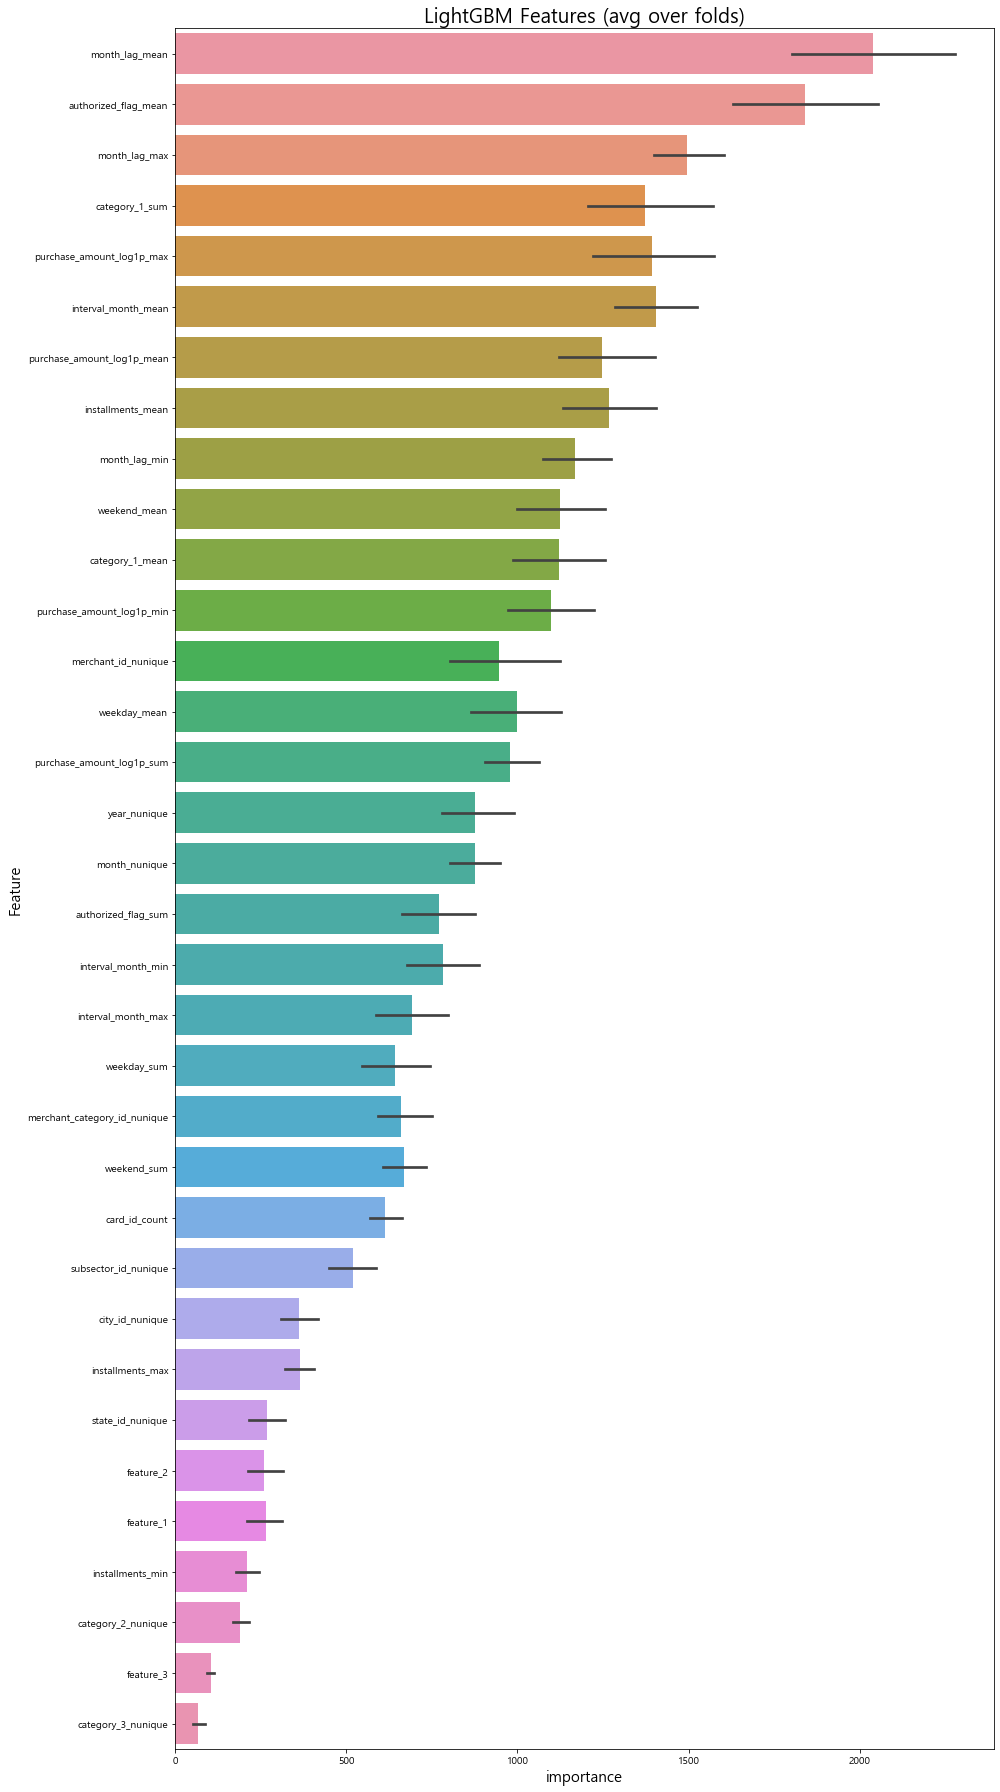

In [13]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

#plt.figure(figsize=(14,25))
#sns.barplot(x="importance",
#            y="Feature",
#            data=best_features.sort_values(by="importance",
#                                           ascending=False))
#plt.title('LightGBM Features (avg over folds)')
#plt.tight_layout()

## 변수 일단 축소하면서 확인
* 1) Feature_importance가 낮으면서 
* 2) 다중공선성이 높은 변수(변수간 상관관계가 높은 변수) 부터 제거하면서 해보기
     (회귀모형에서 일반적으로 사용하지만 트리모형이라도 한번 비교하기로함...)

In [14]:
#Feature_importance
importance_df=best_features.groupby('Feature').agg({'importance':['mean']}).reset_index()
importance_df.columns = ['_'.join(col).strip() for col in importance_df.columns.values]
importance_df.sort_values(by='importance_mean',ascending=False,inplace=True)
importance_df.reset_index(drop=True,inplace=True)
importance_df.columns=['Features','importance_mean']

#다중공선성
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
VIF = pd.DataFrame()
VIF['VIF Factor']=[variance_inflation_factor(df_train.loc[:,df_train_columns].values,j) for j in range(df_train.loc[:,df_train_columns].shape[1])]
VIF['Features']=df_train.loc[:,df_train_columns].columns
VIF=VIF.sort_values(by='VIF Factor',ascending=False).reset_index(drop=True)

##Features 열 기준으로 두 데이터 프레임 통합
Importance_VIF=pd.merge(importance_df,VIF,how='left',on='Features').sort_values(by=['importance_mean','VIF Factor'],ascending=False)
Importance_VIF

,Features,importance_mean,VIF Factor
0,month_lag_mean,2040.2,3710.282839
1,authorized_flag_mean,1841.8,121.300101
2,month_lag_max,1494.2,785.934123
3,interval_month_mean,1404.8,29401.822904
4,purchase_amount_log1p_max,1393.4,2.430256
5,category_1_sum,1373.0,2.082323
6,installments_mean,1267.8,4.833013
7,purchase_amount_log1p_mean,1246.4,44.649713
8,month_lag_min,1167.0,4739.748559
9,weekend_mean,1125.6,12.474155


In [20]:
### 제거될 변수 제거하고 다시 모델에 이용할 열만 정리
### 열 초기화
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target',
                                                             'purchase_date_min','purchase_date_max','outliers']]

### 최대 VIF가 10이하일때까지 변수 하나씩 빼가면서 변수조절
### ['interval_month_max','weekday_sum','card_id_count'] 제거하고 다시 돌리기
df_train_columns= [c for c in df_train_columns if c not in ['interval_month_max','interval_month_mean','card_id_count',
                                                              'authorized_flag_sum','purchase_amount_log1p_min',
                                                              'weekday_mean','merchant_category_id_nunique',
                                                              'purchase_amount_log1p_sum','authorized_flag_mean',
                                                              'month_nunique','subsector_id_nunique','month_lag_min','year_nunique',
                                                              'state_id_nunique','category_3_nunique','merchant_id_nunique',
                                                              'purchase_amount_log1p_mean','weekday_sum','feature_1']]
df_train_columns


### VIF다시 확인
VIF2 = pd.DataFrame()
VIF2['VIF Factor']=[variance_inflation_factor(df_train.loc[:,df_train_columns].values,j) for j in range(df_train.loc[:,df_train_columns].shape[1])]
VIF2['Features']=df_train.loc[:,df_train_columns].columns
VIF2=VIF2.sort_values(by='VIF Factor',ascending=False).reset_index(drop=True)
VIF2

,VIF Factor,Features
0,7.009653,category_2_nunique
1,5.554837,feature_2
2,5.510660,city_id_nunique
3,4.976719,weekend_mean
4,4.851207,month_lag_max
5,3.871716,month_lag_mean
6,2.979047,weekend_sum
7,2.967632,installments_mean
8,2.374837,feature_3
9,2.369640,category_1_mean


In [21]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.79137	valid_1's rmse: 3.81758
[200]	training's rmse: 3.76112	valid_1's rmse: 3.80745
[300]	training's rmse: 3.73888	valid_1's rmse: 3.80339
[400]	training's rmse: 3.72121	valid_1's rmse: 3.80124
[500]	training's rmse: 3.70632	valid_1's rmse: 3.80016
[600]	training's rmse: 3.69426	valid_1's rmse: 3.79972
Early stopping, best iteration is:
[556]	training's rmse: 3.69927	valid_1's rmse: 3.79964
fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.78849	valid_1's rmse: 3.82651
[200]	training's rmse: 3.75701	valid_1's rmse: 3.81809
[300]	training's rmse: 3.73438	valid_1's rmse: 3.81629
[400]	training's rmse: 3.71665	valid_1's rmse: 3.81496
[500]	training's rmse: 3.70199	valid_1's rmse: 3.81488
Early stopping, best iteration is:
[441]	training's rmse: 3.71014	valid_1's rmse: 3.8147
fold 2
Training until validation scores don't improve for 100 rounds
[100]	tra

3.8035118234833662

In [24]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

#Feature_importance
importance_df2=best_features.groupby('Feature').agg({'importance':['mean']}).reset_index()
importance_df2.columns = ['_'.join(col).strip() for col in importance_df2.columns.values]
importance_df2.sort_values(by='importance_mean',ascending=False,inplace=True)
importance_df2.reset_index(drop=True,inplace=True)
importance_df2.columns=['Features','importance_mean']

#다중공선성
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
VIF3 = pd.DataFrame()
VIF3['VIF Factor']=[variance_inflation_factor(df_train.loc[:,df_train_columns].values,j) for j in range(df_train.loc[:,df_train_columns].shape[1])]
VIF3['Features']=df_train.loc[:,df_train_columns].columns
VIF3=VIF3.sort_values(by='VIF Factor',ascending=False).reset_index(drop=True)

##Features 열 기준으로 두 데이터 프레임 통합
Importance_VIF2=pd.merge(importance_df2,VIF3,how='left',on='Features').sort_values(by=['importance_mean','VIF Factor'],ascending=False)
Importance_VIF2

,Features,importance_mean,VIF Factor
0,month_lag_mean,2580.2,3.871716
1,purchase_amount_log1p_max,1740.2,1.452464
2,category_1_sum,1706.8,1.806315
3,weekend_mean,1625.6,4.976719
4,weekend_sum,1605.6,2.979047
5,interval_month_min,1572.4,1.403299
6,category_1_mean,1507.0,2.369640
7,installments_mean,1489.6,2.967632
8,month_lag_max,1190.4,4.851207
9,city_id_nunique,535.4,5.510660


In [25]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("D:/kaggle/ELO/data/new/model/submission.csv", index=False)

In [26]:
df_train_columns

['city_id_nunique',
 'category_1_sum',
 'category_1_mean',
 'installments_min',
 'installments_max',
 'installments_mean',
 'month_lag_max',
 'month_lag_mean',
 'purchase_amount_log1p_max',
 'weekend_sum',
 'weekend_mean',
 'category_2_nunique',
 'interval_month_min',
 'feature_2',
 'feature_3']